In [151]:
from quantum_model.system import SingleSystem, CompositeSystem
from quantum_model.dynamics import EnergyExchangeDynamics, QutritQubitExchangeDynamics, LevelCouplingDynamics, QuditEnergyDynamics

from quantum.core import DensityMatrix, GeneralQubitMatrixGen, sigmaZ, randomUnitary
import numpy as np

from itertools import combinations

from reservoir_analysis import ReservoirAnalyser

## 1. System Setup

In [152]:
target_dim = 3
num_nodes = 3

In [153]:
nodes = []

for i in range(num_nodes):
    node = SingleSystem(DensityMatrix(0))
    node.name = f'Node{i}'
    nodeDynamics = QuditEnergyDynamics(node, np.random.rand() *np.array([1,-1]))
    node.addDynamics(nodeDynamics)
    nodes.append(node)

In [154]:
system = CompositeSystem()
system.name = 'Reservoir'

for node in nodes:
    system.addSubsystem(node)

for pair in combinations([i for i in range(len(nodes))], 2):
    dynamic = EnergyExchangeDynamics(nodes[pair[0]], nodes[pair[1]], 0.5*(0.5+np.random.rand()))
    system.addDynamics(dynamic)



In [155]:
model = CompositeSystem()
model.name = 'Model'

target = SingleSystem(DensityMatrix(np.eye(target_dim)))
target.name = 'Target'
targetDynamics = QuditEnergyDynamics(target, [1,0.5,-1])
target.addDynamics(targetDynamics)

model.addSubsystem(target)
model.addSubsystem(system)

for i, node in enumerate(nodes):
    if i < len(nodes)/2:
        interfaceDynamics = LevelCouplingDynamics(target, node, [0,1], [0,1], 1)
    else:
        interfaceDynamics = LevelCouplingDynamics(target, node, [1,2], [0,1], 1)
    model.addDynamics(interfaceDynamics)

model.updateDyanamics()
model.dynamics_manager.precompute_u(.1)

100%|██████████| 8/8 [00:00<00:00, 402.92it/s]


In [156]:
analyser = ReservoirAnalyser([model])

In [157]:
analyser.generateStates(10000, n_qubits=target_dim, state_subset="thermal")

In [158]:
model = analyser.transformStates()

Transforming reservoir 1 of 1


100%|██████████| 10000/10000 [00:04<00:00, 2160.19it/s]


In [159]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import math

dataset = analyser.datasets[-1]

x = dataset.target_states
d = dataset.transformed_states
y=[math.tanh(state.beta) for state in x]
y=[state.beta for state in x]
x_train, x_test, y_train, y_test = train_test_split(d, y, test_size=0.1)

scaler = StandardScaler()
scaler.fit(x_train)

mlp = LinearRegression().fit(scaler.transform(x_train), y_train)
mean_squared_error(mlp.predict(scaler.transform(x_test)), y_test)
#mean_squared_error([math.atanh(val) for val in mlp.predict(x_test)], [math.atanh(val) for val in y_test])

0.34005129206385787

for func in model.dynamics_manager.dynamic_funcs:
    func.hamiltonian.transformed_matrix = None
    try:
        print(func.system1.name, func.system2.name)
    except:
        print(func.system.name)
    print(func.hamiltonian)

In [160]:
np.std(x_test)

0.007640226989654054

In [161]:
np.std(scaler.transform(x_test))

1.0065237616840301

Text(0.5, 1.0, 'Comparison of target and reconstructed $\\beta$')

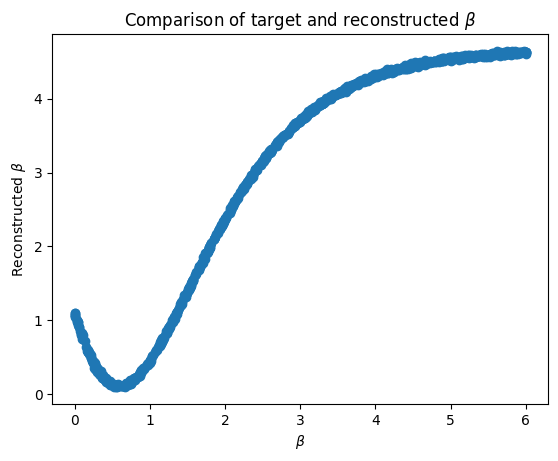

In [162]:
import matplotlib.pyplot as plt
#plt.scatter([math.atanh(val) for val in y_test], [math.atanh(val) for val in mlp.predict(x_test)])
plt.scatter(y_test, mlp.predict(scaler.transform(x_test)))
plt.xlabel(r'$\beta$')
plt.ylabel(r'Reconstructed $\beta$')
plt.title(r'Comparison of target and reconstructed $\beta$')

In [163]:
mlp.coef_

array([ 4.45971692e+11, -4.45964739e+11,  7.08380133e+06])

In [164]:
GeneralQubitMatrixGen().generateThermalState(beta=3.7, dim=3)

[[6.0000e-04+0.j 0.0000e+00+0.j 0.0000e+00+0.j]
 [0.0000e+00+0.j 2.4110e-02+0.j 0.0000e+00+0.j]
 [0.0000e+00+0.j 0.0000e+00+0.j 9.7529e-01+0.j]]

In [165]:
target = model.getSubsystem('Target')

model.state = None
target.state = state

for node in nodes:
    node.state = DensityMatrix(0)

model.computeState()


NameError: name 'state' is not defined

In [ ]:
from quantum.core import Operator
H = 0
for dynamic in model.dynamics_manager.dynamic_funcs:
    H += dynamic.hamiltonian
z_vals = []
t=0
model.dynamics_manager.precompute_u(0.05)
for i in range(500):
    model.evolve()
    t+=0.01
    z_vals_row = [t]
    for node in nodes:
        z_vals_row.append(model.measureSubsystem(node, sigmaZ(2)))
    z_vals_row.append(model.measureSubsystem(model.getSubsystem('Target'), Operator(np.array([[1,0,0],[0,0.5,0],[0,0,-1]]))))            
    z_vals_row.append(model.state.measure(H))
    z_vals.append(z_vals_row)

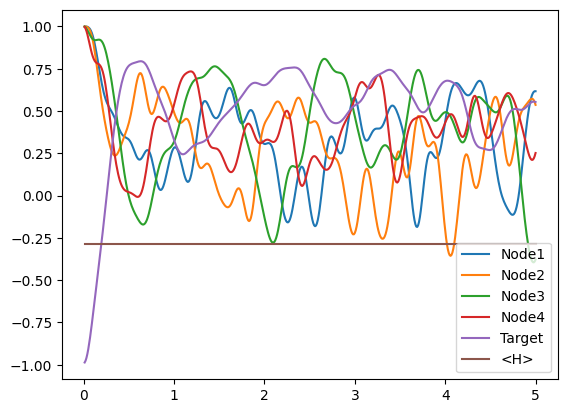

In [ ]:
import matplotlib.pyplot as plt

for i in range(len(nodes)):
    plt.plot([val[0] for val in z_vals], [val[i+1] for val in z_vals], label=f'Node{i+1}')
plt.plot([val[0] for val in z_vals], [val[-2] for val in z_vals], label="Target")
plt.plot([val[0] for val in z_vals], [val[-1] for val in z_vals ], label="<H>")
plt.legend()